# Volumetrics


This module that generates circuits on a graph which represents the QPU or QVM lattice. The basic idea is it will compute error rates of circuits as a function of depth and width.

The `width` of the circuit is the number of connected vertices on a particular subgraph.

The `depth` is defined in context-dependent way; to avoid confusion with circuit depth we may use the term 'repetitions'.

In [1]:
import random
import itertools
import networkx as nx
import numpy as np
import time

from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer, get_benchmarker
from pyquil.gates import CNOT, CCNOT, Z, X, I, H, CZ, MEASURE, RESET
from pyquil.quilbase import Pragma

from forest.benchmarking.volumetrics import *


bm = get_benchmarker()

/home/kylegulshen/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Get lattice

In [2]:
from pyquil import *
# if you want to run on a "real lattice"
#list_quantum_computers()
#perfect_qc = get_qc("Aspen-1-16Q-A", as_qvm=True, noisy=False)
#noisy_qc = get_qc("Aspen-1-16Q-A") #, as_qvm=True, noisy=True)

noisy_qc = get_qc("9q-square-qvm", as_qvm=True, noisy=True)
perfect_qc = get_qc("9q-square-qvm", as_qvm=True, noisy=False)

/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


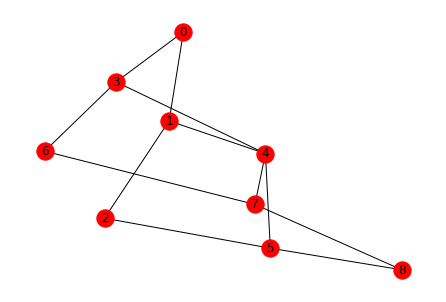

In [3]:
nx.draw(perfect_qc.qubit_topology(),with_labels=True)

In [4]:
G = perfect_qc.qubit_topology()

## Gate sets

### Classical

In [5]:
def two_q_id(qb1,qb2):
    prog = Program()
    prog +=I(qb1)
    prog +=I(qb2)
    return prog

one_c_gates = [X,I]
two_c_gates = [two_q_id, CNOT]
two_c_toffoli = two_c_gates + [CCNOT]

# x basis gates
from forest.benchmarking.classical_logic import CNOT_X_basis, CCNOT_X_basis
one_x_c_gates = [Z, I]
two_x_c_gates = [two_q_id, CNOT_X_basis]
two_x_c_toffoli = two_x_c_gates + [CCNOT_X_basis]
# if you want to do something in the X basis, add Hadamard layers appropriately; see below.

### Some quantum

In [6]:
one_q_gates = [X,Z,I]
two_q_gates = [two_q_id,CZ]

### Random Cliffords

We use a benchmarker for this. Typically we use the native gates from `get_rb_gateset` to implement each clifford.

In [7]:
from forest.benchmarking.randomized_benchmarking import get_rb_gateset
print(bm.generate_rb_sequence(depth=2, gateset=get_rb_gateset([0]))[0])

RX(pi/2) 0



## Get random gates on a graph

In [8]:
from forest.benchmarking.volumetrics._generators import random_single_qubit_gates, random_two_qubit_gates
prog1 = random_single_qubit_gates(G, one_q_gates)
prog2 = random_two_qubit_gates(G, two_q_gates)
print(prog1+prog2)

X 0
I 1
X 2
Z 3
Z 4
I 5
X 6
X 7
I 8
I 0
I 3
CZ 0 1
I 1
I 4
CZ 1 2
I 2
I 5
CZ 3 6
I 3
I 4
I 4
I 7
I 4
I 5
CZ 5 8
I 6
I 7
I 7
I 8



In [9]:
from forest.benchmarking.volumetrics._generators import random_single_qubit_cliffords

rand1qcliff = random_single_qubit_cliffords(bm, G)
print(rand1qcliff)

RX(-pi/2) 0
RZ(-pi/2) 0
RX(-pi/2) 0
RX(-pi/2) 1
RZ(-pi/2) 1
RX(-pi) 2
RZ(-pi/2) 3
RX(pi/2) 3
RZ(pi/2) 4
RX(-pi) 4
RX(pi/2) 5
RZ(-pi) 5
RX(pi/2) 6
RZ(pi/2) 6
RZ(-pi) 7
RZ(-pi) 7
RX(-pi/2) 8
RZ(pi/2) 8
RX(-pi/2) 8



## Make some circuit templates and sample programs from them


In [10]:
classical_1q_layer = get_rand_1q_template(one_c_gates)
print(classical_1q_layer.sample_program(G, repetitions=2, width=2))

I 5
X 8
X 5
X 8



In [11]:
classical_2q_layer = get_rand_2q_template(two_c_gates)
print(classical_2q_layer.sample_program(G, repetitions=2, width=2))

CNOT 6 7
CNOT 6 7



In [12]:
clifford_1q_layer = get_rand_1q_cliff_template(bm)
clifford_2q_layer = get_rand_2q_cliff_template(bm)
print(clifford_2q_layer.sample_program(G, repetitions=2, width=2))

CZ 4 5
RZ(pi/2) 5
RX(pi/2) 5
RX(pi/2) 4
CZ 4 5
RX(pi/2) 5
RZ(-pi/2) 5
RX(-pi/2) 4
CZ 4 5
RX(-pi/2) 5
RZ(pi/2) 4
RX(pi/2) 4
CZ 4 5
RX(-pi/2) 5
RX(pi/2) 4
CZ 4 5
RX(-pi/2) 5



In [13]:
rand_su4_layer = get_rand_su4_template()
print(rand_su4_layer.sample_program(G, 1, qc=noisy_qc, width=2))


DEFGATE LYR0_RSU4_8_5:
    -0.06740625349879759-0.014045321406165294i, 0.2968943368678356-0.4765007530477127i, 0.15175567111229893-0.30564943412758033i, -0.6954532809045382-0.2827601188259824i
    0.6638702337657884+0.026452398485650015i, -0.09700059763023283+0.11342360586736261i, 0.24893503615880685-0.6703191115524492i, 0.15689771231565453+0.019730619752048928i
    -0.36190874503911585-0.3828986284927636i, -0.07124472148124422-0.5342898321092627i, 0.34887965587582004-0.20161203347299655i, 0.5142180741895144+0.07130646099736504i
    0.4754516917187752-0.2240359316589525i, -0.49516048709318333-0.35609185859768144i, 0.021039783792687297+0.4576518079672631i, -0.05393976351873825-0.37278803964631857i

LYR0_RSU4_8_5 8 5



## Compose templates

In [14]:
classical_1q_2q = classical_1q_layer + classical_2q_layer
print(classical_1q_2q.sample_program(G, repetitions=2, width=4))

X 2
X 3
X 4
X 5
CNOT 2 5
CNOT 3 4
CNOT 4 5
X 2
I 3
I 4
X 5
CNOT 2 5
CNOT 3 4
I 4
I 5



Classical Logic in X basis

Add a `sequence_transform` for the template to insert the basis change H gates at beginning and end.

In [15]:
classical_x_1q_2q = get_rand_1q_template(one_x_c_gates) + get_rand_2q_template(two_x_c_gates)
# here we demonstrate a simple use of a sequence_transform. We want to switch to the x basis 
# at thebeginning of our circuite and switch back to the Z basis before measurement. 
# To accomplish this we set a 'sequnce_transform' to be applied after the circuit sequence is generated.
classical_x_1q_2q.sequence_transforms.append(hadamard_sandwich)
print(classical_x_1q_2q.sample_program(G, repetitions=3, width=2))
# note that the x basis CNOT(0, 1) is H(0) CZ(0, 1) H(0)

H 0
H 1
I 0
I 1
H 0
CZ 0 1
H 0
Z 0
I 1
H 0
CZ 0 1
H 0
I 0
Z 1
I 0
I 1
H 0
H 1



Daggering the circuit to get a self-inverting sandwich.
Here we again add a `sequence_transform` to transform the sampled sequence by appending its dagger (aka Hermitian conjugate, adjoint, etc.).

In [16]:
clifford_sandwich = clifford_1q_layer + clifford_2q_layer
clifford_sandwich.sequence_transforms.append(dagger_sequence)
prog = clifford_sandwich.sample_program(G, repetitions=3, width=2,  qc=noisy_qc)
print(prog)

# We can check that this is the identity by compiling it fully
print("This program compiles away to nothing: ")
print(noisy_qc.compiler.quil_to_native_quil(prog))

RX(-pi/2) 1
RX(pi/2) 4
RZ(pi/2) 4
RX(-pi/2) 4
CZ 1 4
RZ(-pi/2) 4
RX(pi/2) 4
RX(pi/2) 1
CZ 1 4
RZ(-pi/2) 4
RZ(pi/2) 1
RZ(-pi) 1
RZ(-pi/2) 4
RX(-pi) 4
RX(-pi/2) 4
CZ 1 4
RX(-pi/2) 1
CZ 1 4
RX(-pi/2) 4
RZ(-pi/2) 4
RX(-pi/2) 4
RZ(-pi) 1
RZ(pi/2) 1
RX(-pi) 4
RX(-pi/2) 4
RX(pi/2) 1
CZ 1 4
RX(pi/2) 4
RZ(-pi/2) 1
RX(pi/2) 1
CZ 1 4
RX(-pi/2) 4
RX(-pi/2) 1
DAGGER RX(-pi/2) 1
DAGGER RX(-pi/2) 4
DAGGER CZ 1 4
DAGGER RX(pi/2) 1
DAGGER RZ(-pi/2) 1
DAGGER RX(pi/2) 4
DAGGER CZ 1 4
DAGGER RX(pi/2) 1
DAGGER RX(-pi/2) 4
DAGGER RX(-pi) 4
DAGGER RZ(pi/2) 1
DAGGER RZ(-pi) 1
DAGGER RX(-pi/2) 4
DAGGER RZ(-pi/2) 4
DAGGER RX(-pi/2) 4
DAGGER CZ 1 4
DAGGER RX(-pi/2) 1
DAGGER CZ 1 4
DAGGER RX(-pi/2) 4
DAGGER RX(-pi) 4
DAGGER RZ(-pi/2) 4
DAGGER RZ(-pi) 1
DAGGER RZ(pi/2) 1
DAGGER RZ(-pi/2) 4
DAGGER CZ 1 4
DAGGER RX(pi/2) 1
DAGGER RX(pi/2) 4
DAGGER RZ(-pi/2) 4
DAGGER CZ 1 4
DAGGER RX(-pi/2) 4
DAGGER RZ(pi/2) 4
DAGGER RX(pi/2) 4
DAGGER RX(-pi/2) 1

This program compiles away to nothing: 
HALT



### Quantum Volume

You could easily make your own Quantum Volume template:

In [17]:
from forest.benchmarking.volumetrics._transforms import compile_merged_sequence
custom_qv_template = rand_su4_layer
# we want to compile the output sequences with graph-restricted compilation.
custom_qv_template.sequence_transforms.append(compile_merged_sequence)
qv_prog = custom_qv_template.sample_program(G, repetitions=2, qc=noisy_qc, width=4)
print(qv_prog)

RZ(2.4567535228446093) 2
RX(pi/2) 2
RZ(1.9079844139625592) 2
RX(-pi/2) 2
RZ(-0.98387329480434) 2
RZ(-2.9491179617564063) 5
RX(pi/2) 5
RZ(1.8350280635126637) 5
RX(-pi/2) 5
RZ(2.9144094282733226) 5
CZ 2 5
RZ(-pi/2) 2
RX(-pi/2) 2
RZ(pi/2) 5
RX(pi/2) 5
RZ(2.555017505371151) 5
RX(-pi/2) 5
CZ 2 5
RZ(1.8140489262142276) 2
RX(pi/2) 2
RX(pi/2) 5
RZ(-1.5878683423805606) 5
RX(-pi/2) 5
CZ 2 5
RZ(-1.810401907235648) 8
RX(pi/2) 8
RZ(1.5887962435158791) 8
RX(-pi/2) 8
RZ(-2.180441355911783) 8
RZ(2.9971046352051487) 1
RX(pi/2) 1
RZ(1.7590571700067648) 1
RX(-pi/2) 1
RZ(-1.4375538292718586) 1
RZ(-0.2950219757493664) 2
RX(pi/2) 2
RZ(1.3247687649811228) 2
RX(-pi/2) 2
CZ 2 1
RZ(-1.4015247592496605) 1
RX(pi/2) 1
RZ(1.7400678943401324) 2
RX(-pi/2) 2
CZ 2 1
RX(-pi/2) 1
RX(pi/2) 2
CZ 2 1
RZ(2.713646613685171) 5
RX(pi/2) 5
RZ(1.8323569565381046) 5
RX(-pi/2) 5
CZ 8 5
RZ(-1.3009855714721716) 5
RX(pi/2) 5
RZ(-pi/2) 8
RX(-pi/2) 8
CZ 8 5
RX(-pi/2) 5
RX(pi/2) 8
CZ 8 5
RZ(-0.6349319473600517) 1
RX(pi/2) 1
RZ(1.97086386

but we also provide this template

In [18]:
qv_template = get_quantum_volume_template()
print(qv_template.sample_program(G, repetitions=2, qc=noisy_qc, width=2))

RZ(-0.16578807316550104) 1
RX(pi/2) 1
RZ(0.8951760925703465) 1
RX(-pi/2) 1
RZ(-3.10079491833949) 1
RZ(-1.4409737603193395) 4
RX(pi/2) 4
RZ(1.3605854011246243) 4
RX(-pi/2) 4
RZ(-2.4254994565738994) 4
CZ 4 1
RZ(pi/2) 1
RX(pi/2) 1
RZ(2.595980783014279) 1
RX(-pi/2) 1
RZ(-pi/2) 4
RX(-pi/2) 4
CZ 4 1
RX(pi/2) 1
RZ(-1.6629939074364621) 1
RX(-pi/2) 1
RZ(1.804901097823322) 4
RX(pi/2) 4
CZ 4 1
RZ(1.4253771658324803) 1
RX(pi/2) 1
RZ(1.912096271646144) 1
RX(-pi/2) 1
RZ(2.072941377163399) 1
RZ(0.7670487358338374) 4
RX(-pi/2) 4
RZ(1.8935724315033482) 4
RX(-pi/2) 4
RZ(2.6425255170910775) 4



## First, an example of a single width and depth 

We'll use the Quantum Volume template to demonstrate.

Run quantum volume for one width and depth

1. Generate the programs
2. Collect experimental data
3. Determine the heavy outputs -- this uses the special quantum volume submodule

This can be a bit slow

In [19]:
# 1) Generate the programs for this circuit template with the given {width: [depths]} dimensions
d = 2  # depth = width for quantum volume
dimensions = {d: [d]}
qv_progs = generate_volumetric_program_array(perfect_qc, qv_template, 
                                             dimensions, num_circuit_samples=200)

# 2) Run each of these programs on a quantum resource, here a QVM without noise.
experimental_data = acquire_volumetric_data(perfect_qc, qv_progs)

In [20]:
from pyquil.numpy_simulator import NumpyWavefunctionSimulator
from forest.benchmarking.volumetrics.quantum_volume import collect_heavy_outputs

wfn_sim = NumpyWavefunctionSimulator(9)

# 3) For quantum volume we need to simulate the whole circuit.
# For this we use a dedicated fumction from the `quantum_volume` sub module
heavy_outputs = collect_heavy_outputs(wfn_sim, qv_progs)

Now for this example we can perform the analysis for quantum volume using more functions from the `quantum_volume` module

In [23]:
from forest.benchmarking.volumetrics.quantum_volume import (get_success_probabilities,
                                                            determine_prob_success_lower_bounds,
                                                            determine_successes)

qvol_success_probs = get_success_probabilities(experimental_data, heavy_outputs)
print(np.average(qvol_success_probs[d][d]))

print(determine_prob_success_lower_bounds(qvol_success_probs, 500))

qvol_successes = determine_successes(qvol_success_probs, 500)
print(qvol_successes)

0.7865600000000006
{2: {2: 0.7286146177163358}}
{2: {2: True}}


## Acquire data for ranges of (width, depth)

Here we will use a more generic type of volumetric benchmark whith a single ideal solution. We will run this template on a larger collection of different widths and depths. The basic idea is the same:

1. generate the program samples from the circuit family
2. collect data for each program
3. analyse, potentially utilizing ideal simulations (we do here)

In [24]:
widths = [2, 3, 4, 5]
depths = [2, 3, 4, 5, 10]
dimensions = {w: depths for w in widths}
ckt_family = classical_1q_2q
prog_array = generate_volumetric_program_array(noisy_qc, ckt_family, dimensions, num_circuit_samples=20)
print(prog_array)

{2: {2: [<pyquil.quil.Program object at 0x7f0929e98f98>, <pyquil.quil.Program object at 0x7f0929e988d0>, <pyquil.quil.Program object at 0x7f0929eba4e0>, <pyquil.quil.Program object at 0x7f0929eba940>, <pyquil.quil.Program object at 0x7f0929ebada0>, <pyquil.quil.Program object at 0x7f0929eb9278>, <pyquil.quil.Program object at 0x7f0929eb96d8>, <pyquil.quil.Program object at 0x7f0929eb9be0>, <pyquil.quil.Program object at 0x7f0929eb9f98>, <pyquil.quil.Program object at 0x7f0929eb4438>, <pyquil.quil.Program object at 0x7f0929eb4898>, <pyquil.quil.Program object at 0x7f0929eb4da0>, <pyquil.quil.Program object at 0x7f0929eb4828>, <pyquil.quil.Program object at 0x7f0929eb9668>, <pyquil.quil.Program object at 0x7f098cf044a8>, <pyquil.quil.Program object at 0x7f09301dce80>, <pyquil.quil.Program object at 0x7f093079c8d0>, <pyquil.quil.Program object at 0x7f093019f8d0>, <pyquil.quil.Program object at 0x7f093019fb70>, <pyquil.quil.Program object at 0x7f093019f5c0>], 3: [<pyquil.quil.Program objec

These are slow

In [25]:
num_shots = 500
noisy_results = acquire_volumetric_data(noisy_qc, prog_array, num_shots)

In [26]:
ideal_results = acquire_volumetric_data(perfect_qc, prog_array, num_shots=1)
print(ideal_results)

{2: {2: [array([[1, 1]]), array([[0, 1]]), array([[1, 1]]), array([[1, 0]]), array([[1, 0]]), array([[1, 0]]), array([[1, 0]]), array([[1, 0]]), array([[1, 0]]), array([[0, 0]]), array([[1, 1]]), array([[0, 0]]), array([[0, 0]]), array([[0, 0]]), array([[0, 0]]), array([[0, 0]]), array([[1, 1]]), array([[1, 0]]), array([[0, 0]]), array([[1, 1]])], 3: [array([[0, 0]]), array([[1, 0]]), array([[0, 0]]), array([[1, 1]]), array([[0, 1]]), array([[1, 1]]), array([[0, 0]]), array([[1, 1]]), array([[0, 0]]), array([[1, 1]]), array([[1, 0]]), array([[1, 1]]), array([[1, 0]]), array([[1, 1]]), array([[1, 1]]), array([[0, 0]]), array([[0, 0]]), array([[0, 0]]), array([[1, 1]]), array([[0, 0]])], 4: [array([[1, 1]]), array([[1, 1]]), array([[0, 0]]), array([[1, 1]]), array([[0, 0]]), array([[1, 1]]), array([[0, 0]]), array([[1, 0]]), array([[0, 1]]), array([[0, 0]]), array([[0, 0]]), array([[0, 0]]), array([[1, 0]]), array([[0, 0]]), array([[1, 1]]), array([[1, 1]]), array([[1, 1]]), array([[1, 1

In [27]:
err_hamm_distrs = get_error_hamming_weight_distributions(noisy_results, ideal_results)
print(err_hamm_distrs)

{2: {2: [array([0.84, 0.15, 0.01]), array([0.884, 0.112, 0.004]), array([0.838, 0.148, 0.014]), array([0.898, 0.096, 0.006]), array([0.884, 0.116, 0.   ]), array([0.914, 0.08 , 0.006]), array([0.896, 0.102, 0.002]), array([0.878, 0.12 , 0.002]), array([0.876, 0.124, 0.   ]), array([0.942, 0.058, 0.   ]), array([0.852, 0.132, 0.016]), array([0.95, 0.05, 0.  ]), array([0.946, 0.052, 0.002]), array([0.942, 0.058, 0.   ]), array([0.952, 0.048, 0.   ]), array([0.952, 0.048, 0.   ]), array([0.832, 0.16 , 0.008]), array([0.892, 0.102, 0.006]), array([0.94 , 0.052, 0.008]), array([0.8  , 0.194, 0.006])], 3: [array([0.942, 0.056, 0.002]), array([0.848, 0.15 , 0.002]), array([0.95 , 0.044, 0.006]), array([0.852, 0.144, 0.004]), array([0.894, 0.102, 0.004]), array([0.804, 0.188, 0.008]), array([0.932, 0.068, 0.   ]), array([0.846, 0.138, 0.016]), array([0.944, 0.054, 0.002]), array([0.84 , 0.154, 0.006]), array([0.88, 0.12, 0.  ]), array([0.818, 0.168, 0.014]), array([0.896, 0.102, 0.002]), array

In [28]:
avg_err_hamm_distrs = average_distributions(err_hamm_distrs)
print(avg_err_hamm_distrs)

{2: {2: array([0.8954, 0.1001, 0.0045]), 3: array([0.8873, 0.1077, 0.005 ]), 4: array([0.8841, 0.1105, 0.0054]), 5: array([0.9092, 0.0879, 0.0029]), 10: array([0.8751, 0.1146, 0.0103])}, 3: {2: array([8.113e-01, 1.738e-01, 1.450e-02, 4.000e-04]), 3: array([8.189e-01, 1.689e-01, 1.140e-02, 8.000e-04]), 4: array([0.8251, 0.159 , 0.0141, 0.0018]), 5: array([0.8265, 0.1599, 0.0125, 0.0011]), 10: array([0.8107, 0.1646, 0.0211, 0.0036])}, 4: {2: array([0.7823, 0.1953, 0.0212, 0.0012, 0.    ]), 3: array([8.024e-01, 1.759e-01, 2.030e-02, 1.000e-03, 4.000e-04]), 4: array([7.831e-01, 1.946e-01, 2.030e-02, 1.900e-03, 1.000e-04]), 5: array([7.499e-01, 2.196e-01, 2.680e-02, 3.600e-03, 1.000e-04]), 10: array([0.7342, 0.2173, 0.0415, 0.006 , 0.001 ])}, 5: {2: array([7.450e-01, 2.201e-01, 3.190e-02, 2.600e-03, 4.000e-04, 0.000e+00]), 3: array([7.446e-01, 2.255e-01, 2.550e-02, 3.700e-03, 7.000e-04, 0.000e+00]), 4: array([7.298e-01, 2.331e-01, 3.190e-02, 3.300e-03, 1.500e-03, 4.000e-04]), 5: array([7.05

## Plot a particular depth and width

In [29]:
w = 3 # width
d = 4 # depth

avg_distr = avg_err_hamm_distrs[3][4]

# rand data
rand_distr = get_random_hamming_wt_distr(w)

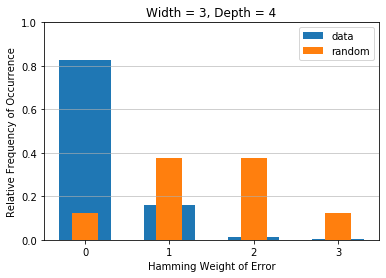

In [30]:
x_labels = np.arange(0, len(avg_distr))
plt.bar(x_labels, avg_distr, width=0.61, align='center')
plt.bar(x_labels, rand_distr, width=0.31, align='center')
plt.xticks(x_labels)
plt.xlabel('Hamming Weight of Error')
plt.ylabel('Relative Frequency of Occurrence')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.75)
plt.legend(['data','random'])
plt.title(f'Width = {w}, Depth = {d}')
plt.show()

Using our helper function

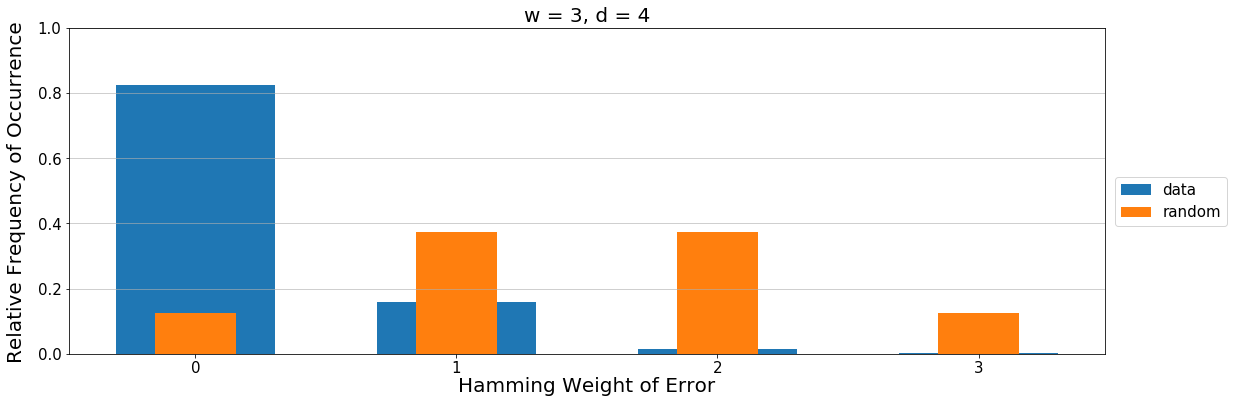

In [33]:
from forest.benchmarking.volumetrics.plotting import plot_error_distributions
fig, axs = plot_error_distributions(avg_err_hamm_distrs, widths=[w], depths=[d], plot_rand_distr=True)

### For a particular width, plot all depths

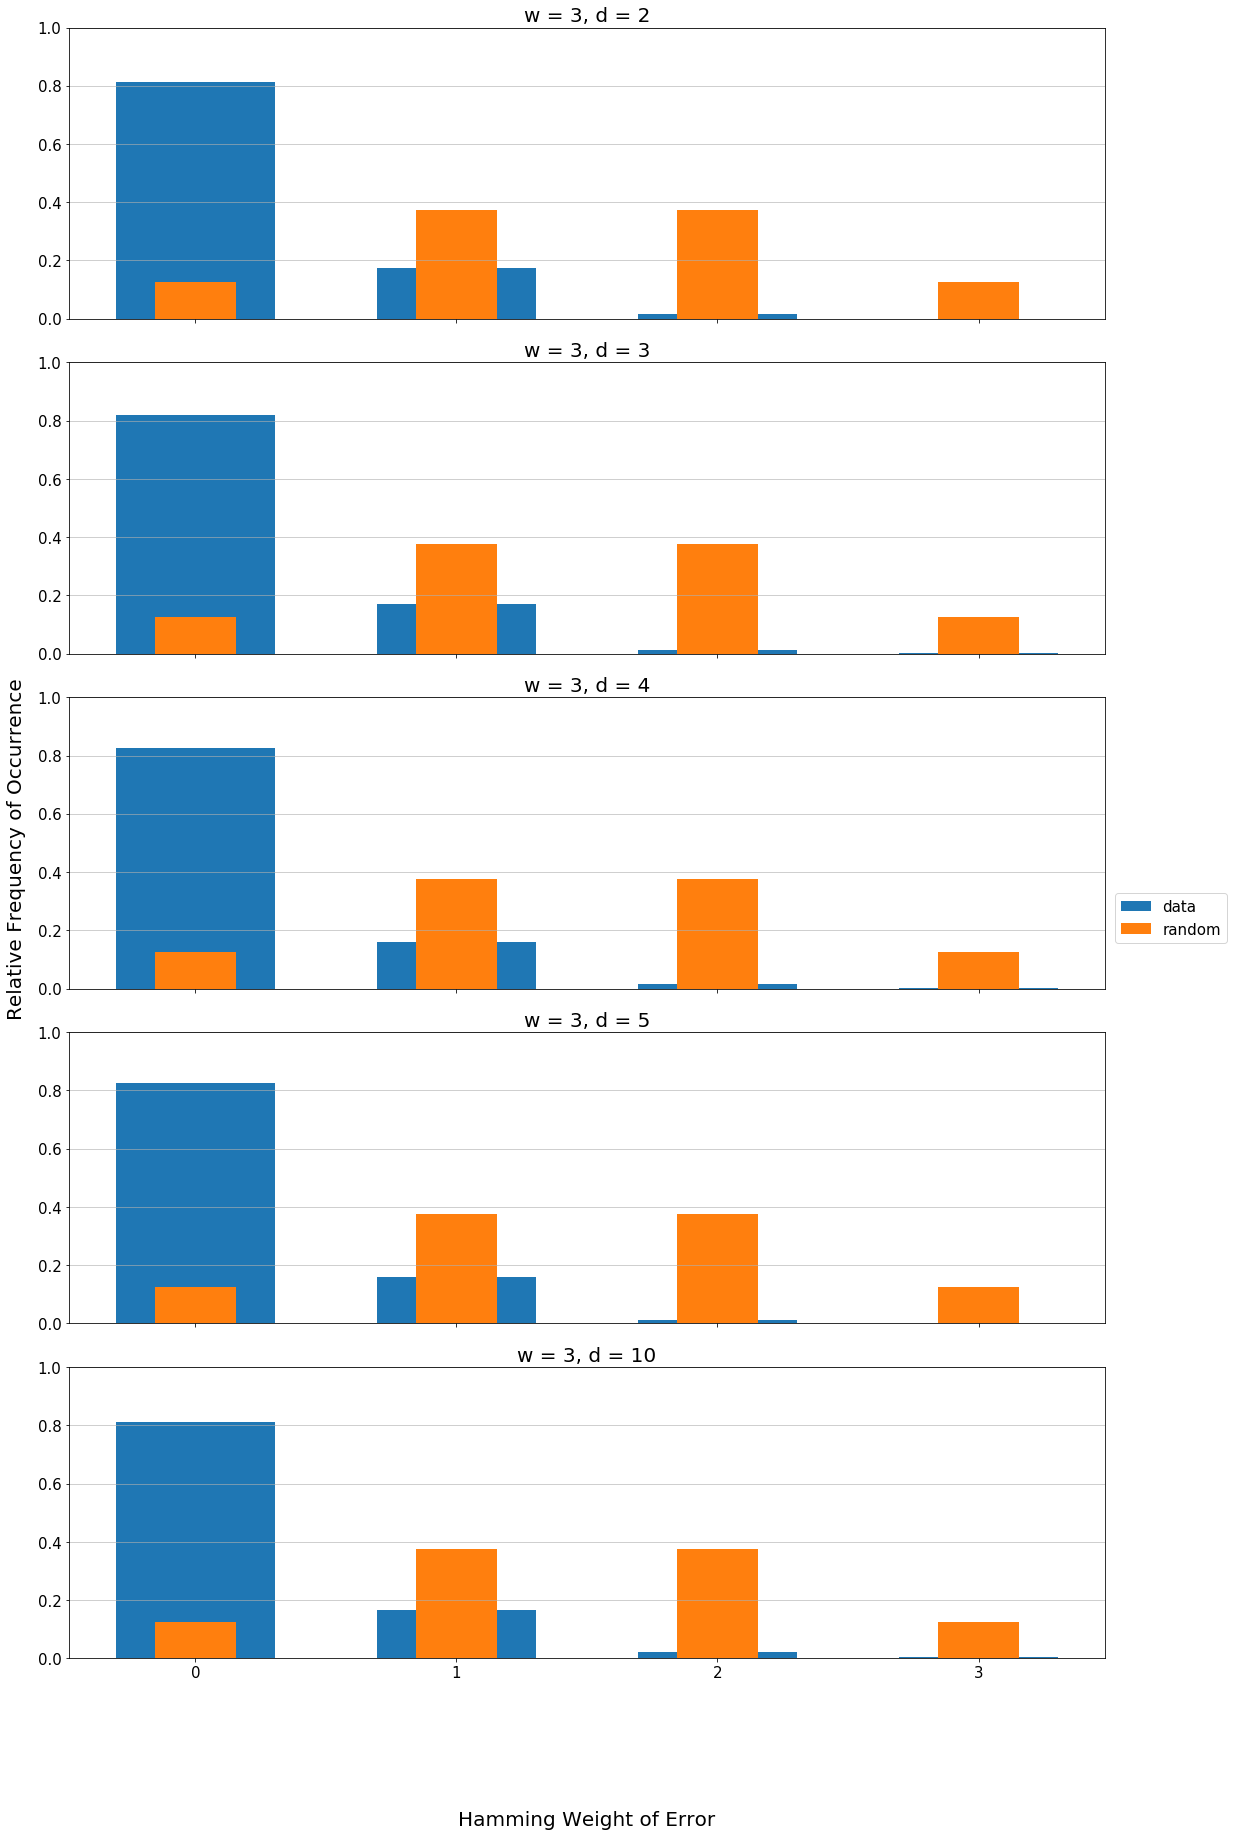

In [34]:
fig, axs = plot_error_distributions(avg_err_hamm_distrs, widths=[w], plot_rand_distr=True)

### Plot all of the distributions

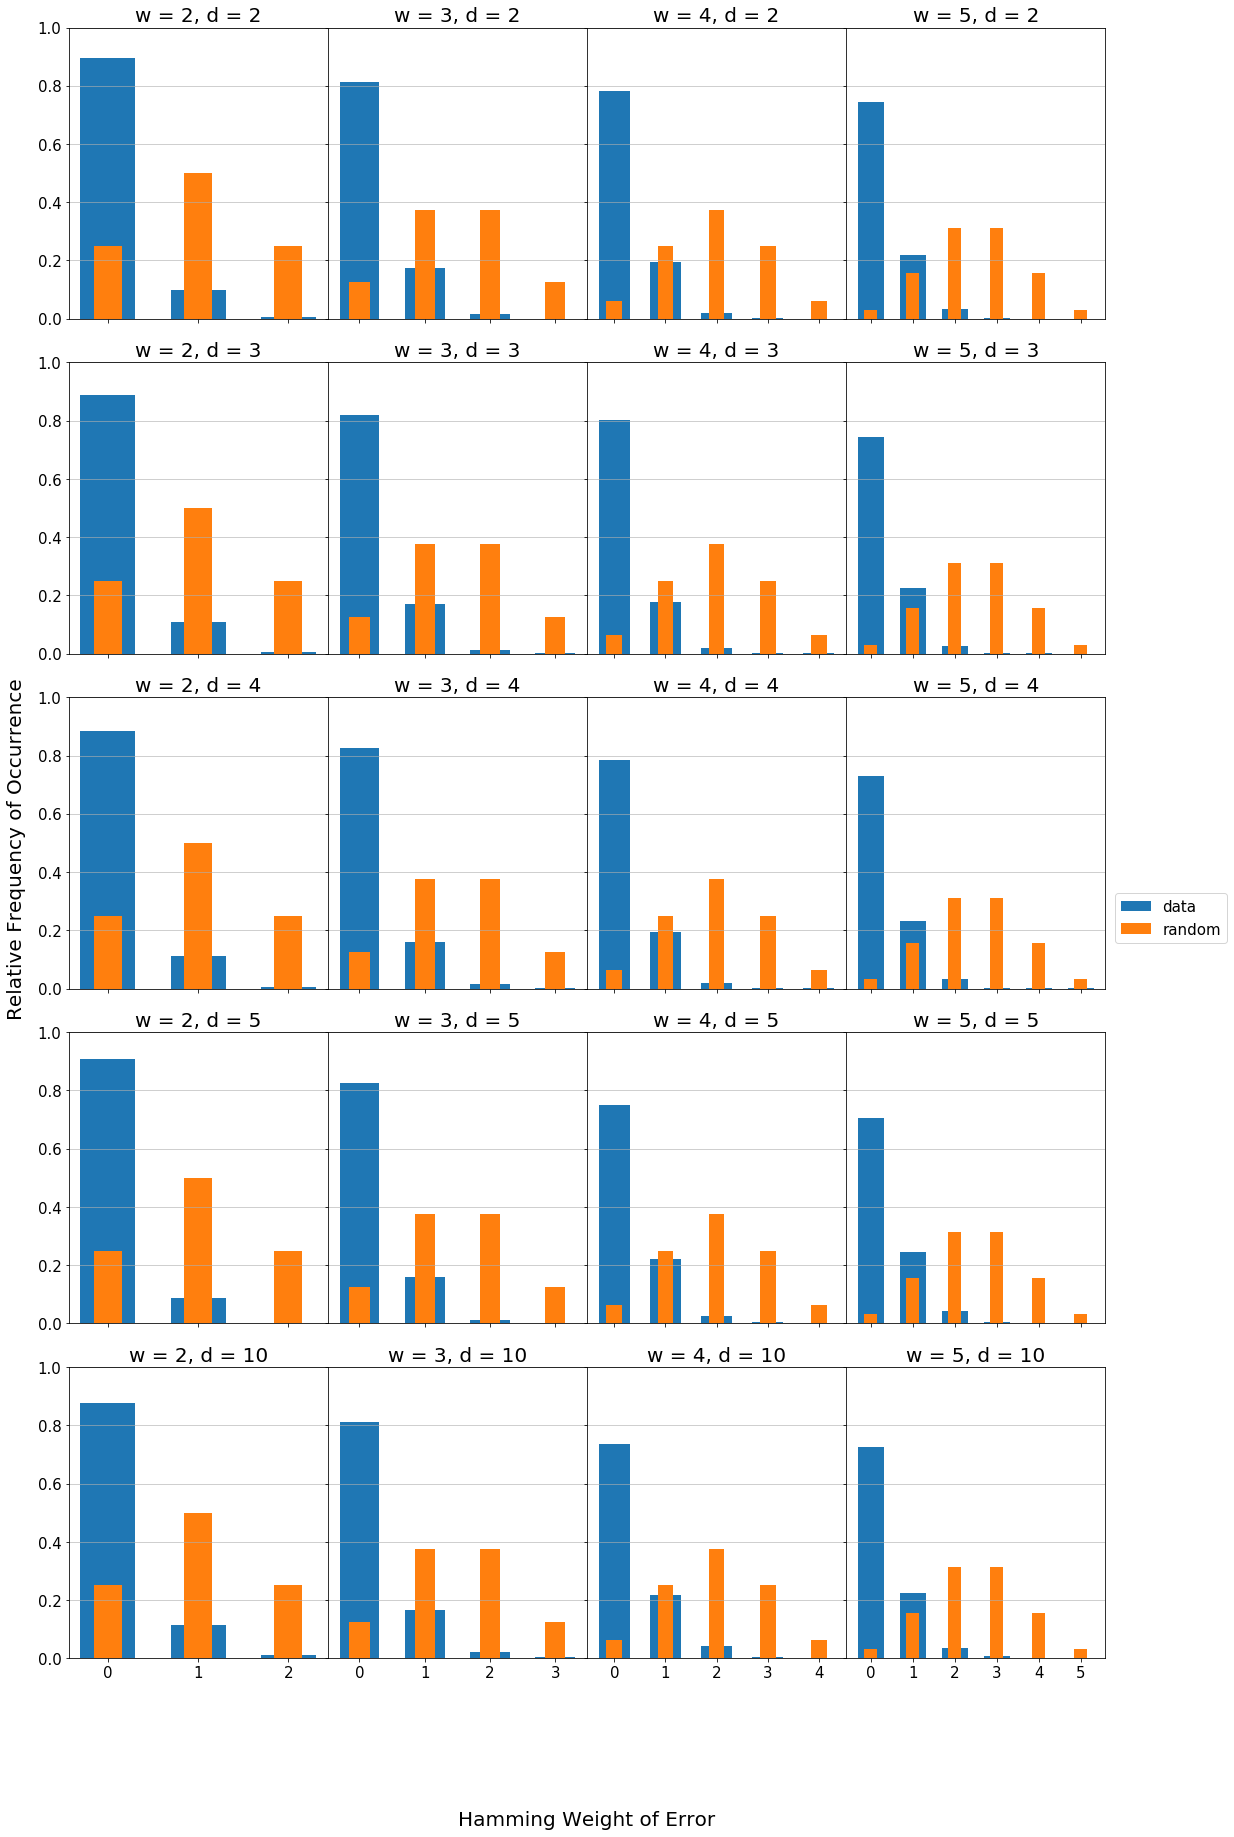

In [35]:
fig, axs = plot_error_distributions(avg_err_hamm_distrs, widths=None, depths=None, plot_rand_distr=True)

Now we can study the sucess probablity, i.e. the zero hamming weight entry above as a function of depth. We first need to extract the data.

In [36]:
# extract data from avg_err_hamm_distrs
widths = list(avg_err_hamm_distrs.keys())
depths = list(avg_err_hamm_distrs[widths[0]].keys())

# get the probability of success for each circuit sampled
succ_probs = get_single_target_success_probabilities(noisy_results, ideal_results)

# get the average probability of success over all samples
avg_pr_succ_arr = {w: {d: distr[0] for d, distr in d_distrs.items()} for w, d_distrs in avg_err_hamm_distrs.items()}
# this is equivalently wrapped up in the following
assert avg_pr_succ_arr == average_distributions(succ_probs)

# count as success even if there are log many bits incorrect.
avg_pr_succ_allow_log_errors = average_distributions(get_single_target_success_probabilities(noisy_results, 
                                                                                             ideal_results, 
                                                     allowed_errors = basement_log_function))

ideal_distrs = {w: [1] + [0 for _ in range(w)] for w in widths}
rand_distrs = {w: get_random_hamming_wt_distr(w) for w in widths}

pr_succ_rand = {w: 1/2**w for w in widths}
pr_succ_rand_allow_log_errors = {w: sum(rand_distrs[w][0:basement_log_function(w)+1]) for w in widths}

# total variation distance
tvd_noisy_ideal = {w: {d: get_total_variation_dist(distr, ideal_distrs[w]) for d, distr in d_distrs.items()}
                              for w, d_distrs in avg_err_hamm_distrs.items()}

# tvd_noisy_ideal is equivalent to 1 - success probability.
np.testing.assert_allclose([pr for d_vals in avg_pr_succ_arr.values() for pr in d_vals.values()], 
                           [1 - val for d_vals in tvd_noisy_ideal.values() for val in d_vals.values()])

tvd_noisy_rand = {w: {d: get_total_variation_dist(distr, rand_distrs[w]) for d, distr in d_distrs.items()}
                              for w, d_distrs in avg_err_hamm_distrs.items()}

print(avg_pr_succ_arr)
print(avg_pr_succ_allow_log_errors)
print(tvd_noisy_rand)

{2: {2: 0.8954000000000001, 3: 0.8873000000000001, 4: 0.8841000000000001, 5: 0.9091999999999999, 10: 0.8751}, 3: {2: 0.8112999999999999, 3: 0.8189, 4: 0.8251, 5: 0.8264999999999999, 10: 0.8107}, 4: {2: 0.7823, 3: 0.8024000000000001, 4: 0.7831000000000001, 5: 0.7499, 10: 0.7342}, 5: {2: 0.7449999999999999, 3: 0.7445999999999999, 4: 0.7298, 5: 0.7051, 10: 0.7268999999999999}}
{2: {2: 0.9955, 3: 0.9949999999999999, 4: 0.9945999999999998, 5: 0.9971, 10: 0.9896999999999998}, 3: {2: 0.9851000000000001, 3: 0.9878000000000002, 4: 0.9841000000000001, 5: 0.9864, 10: 0.9753000000000001}, 4: {2: 0.9987999999999999, 3: 0.9986, 4: 0.9979999999999999, 5: 0.9963, 10: 0.9929999999999998}, 5: {2: 0.9969999999999999, 3: 0.9956000000000002, 4: 0.9948, 5: 0.9938999999999998, 10: 0.9879}}
{2: {2: 0.6454000000000001, 3: 0.6373, 4: 0.6341, 5: 0.6592, 10: 0.6251}, 3: {2: 0.6863, 3: 0.6939, 4: 0.7001, 5: 0.7014999999999999, 10: 0.6857}, 4: {2: 0.7197999999999999, 3: 0.7399, 4: 0.7206, 5: 0.6874, 10: 0.6717}, 5:

## Success probablity and success probablity including a small number of errors

Next we will plot the success probablity of a circuit with a certain width as a function of depth. 

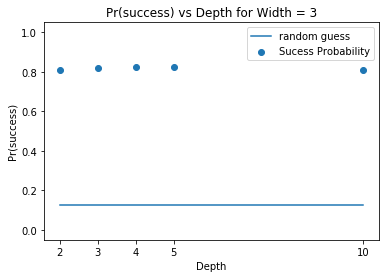

In [37]:
w=3
plt.scatter(depths, [avg_pr_succ_arr[w][d] for d in depths], label='Sucess Probability')
plt.plot(depths, [pr_succ_rand[w] for _ in depths], label='random guess')
plt.ylim([-0.05,1.05])
plt.xlabel('Depth')
plt.xticks(depths)
plt.ylabel('Pr(success)')
plt.title('Pr(success) vs Depth for Width = {}'.format(w))
plt.legend()
plt.show()

**Sucess if we allow for a small number of errors**

Some near term algorithms have robustness to noise. In light of that we might want to consider as successes answers that are only a little wrong.

To make this notion formal we allow a logarithmic number of bits to be flipped from the correct answer and call all such instances "success".

The logarithmic number of bits that we allow to flip is defined by the "basement" ${\mathcal B}$ of 

$\log_2 ({\rm number\ of\ bits})$

where the basement of a number is ${\mathcal B}(number) = 0$ if number$<=0$ and ${\mathcal B}(number) = {\rm floor (number)}$.


Supose we have a circuit of width 4 so that the correct string has four bits, e.g. 1010. Then a logarithmic number of flips is $\log_2(4) = 2$.

So any string with hamming weight zero, one, or two counts as a success.

Such error metrics might be important in noisy near term algorithms where getting the exact answer is not vital.

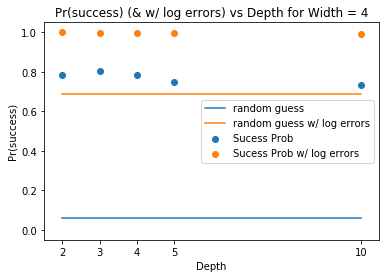

In [38]:
w=4
plt.scatter(depths, [avg_pr_succ_arr[w][d] for d in depths], label='Sucess Prob')
plt.plot(depths, [pr_succ_rand[w] for _ in depths], label='random guess')
plt.scatter(depths, [avg_pr_succ_allow_log_errors[w][d] for d in depths], label='Sucess Prob w/ log errors')
plt.plot(depths, [pr_succ_rand_allow_log_errors[w] for _ in depths], label='random guess w/ log errors')
plt.ylim([-0.05, 1.05])
plt.xlabel('Depth')
plt.xticks(depths)
plt.ylabel('Pr(success)')
plt.title('Pr(success) (& w/ log errors) vs Depth for Width = {}'.format(w))
plt.legend()
plt.show()

## Total variation distance from ideal answer and random distribution

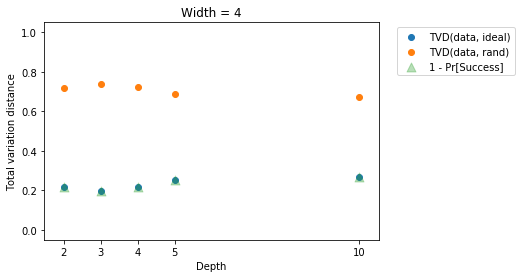

In [39]:
plt.figure()
plt.scatter(depths, [tvd_noisy_ideal[w][d] for d in depths], label='TVD(data, ideal)')
plt.scatter(depths, [tvd_noisy_rand[w][d] for d in depths], label='TVD(data, rand)')
plt.scatter(depths, 1-np.asarray([avg_pr_succ_arr[w][d] for d in depths]),
            label='1 - Pr[Success]', alpha=0.33, marker='^', s=80)
plt.ylim([-0.05,1.05])
plt.xlabel('Depth')
plt.xticks(depths)
plt.ylabel('Total variation distance')
plt.title('Width = {}'.format(w))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

## Plot success probablity landscape

This is just the success probablity as a function of depth and width.

In [40]:
X, Y = np.meshgrid(widths, depths)

In [41]:
Zdata = np.reshape([avg_pr_succ_arr[w][d] for d in depths for w in widths], X.shape)
Zrand = np.reshape([pr_succ_rand[w] for d in depths for w in widths], X.shape)

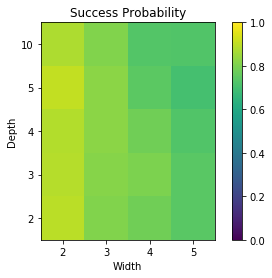

In [42]:
extent = -0.5, len(widths) - 0.5, -0.5, len(depths) - 0.5
ax = plt.gca()
img = ax.imshow(Zdata, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0, vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Success Probability')
plt.show()

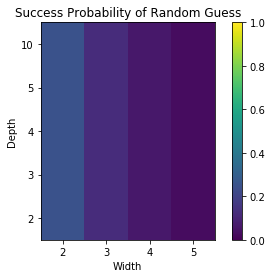

In [43]:
ax = plt.gca()
img = ax.imshow(Zrand, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Success Probability of Random Guess')
plt.show()

(<Figure size 288x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0929343668>)

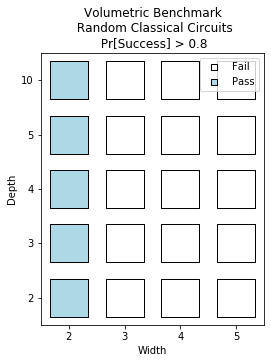

In [45]:
from forest.benchmarking.volumetrics.plotting import plot_success

success_threshold = .8
ckt_success_probs = get_single_target_success_probabilities(noisy_results, ideal_results)
successes = determine_successes(ckt_success_probs, num_shots)
plot_success(successes, f"Volumetric Benchmark\n Random Classical Circuits\n Pr[Success] > {success_threshold}")

(<Figure size 360x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f092942a710>)

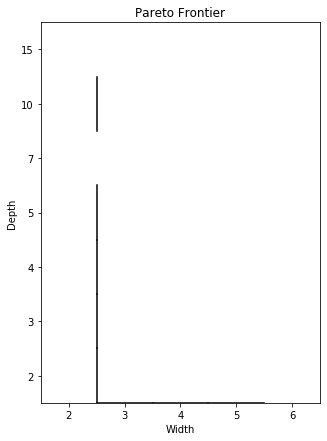

In [48]:
from forest.benchmarking.volumetrics.plotting import plot_pareto_frontier

plot_pareto_frontier(successes, 'Pareto Frontier', widths=[2,3,4,5,6], depths = [2,3,4,5,7,10,15])

## Plot total variation distance landscape

In [49]:
Ztvd_ideal = np.reshape([tvd_noisy_ideal[w][d] for d in depths for w in widths], X.shape)
Ztvd_rand = np.reshape([tvd_noisy_rand[w][d] for d in depths for w in widths], X.shape)

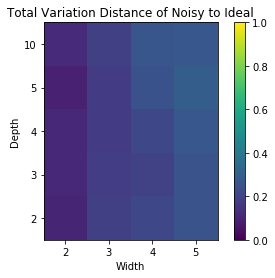

In [50]:
ax = plt.gca()
img = ax.imshow(Ztvd_ideal, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)


ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Total Variation Distance of Noisy to Ideal')
plt.show()

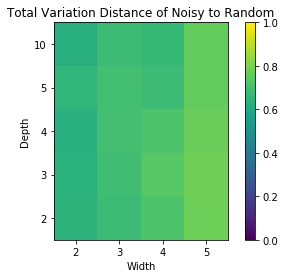

In [51]:
ax = plt.gca()
img = ax.imshow(Ztvd_rand, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Total Variation Distance of Noisy to Random')
plt.show()

## Data exploration

In [52]:
from scipy.optimize import curve_fit

In [53]:
shape = Zdata.shape
size = Zdata.size
width_1d = X.reshape((1,size))
depth_1d = Y.reshape((1,size))
data_1d = Zdata.reshape((1,size))
print(data_1d.shape)
print(width_1d.shape)

(1, 20)
(1, 20)


In [54]:
dims = np.zeros_like(width_1d)
dims[0,0] = shape[0]
dims[0,1] = shape[1]

xdata = np.vstack((dims, width_1d, depth_1d))
xdata

array([[ 5,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 2,  3,  4,  5,  2,  3,  4,  5,  2,  3,  4,  5,  2,  3,  4,  5,
         2,  3,  4,  5],
       [ 2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  5,  5,  5,  5,
        10, 10, 10, 10]])

### Fitting models

Two parameter model 


$f(W,D,p_W,p_D) =  (1-p_W)^W * (1-p_D)^D $

The fidelity is proporional to $1 - p$

In [55]:
def two_param(x, pw, pd):
    num_depths, num_widths = x[0][:2]
    widths = x[1].reshape(num_depths, num_widths)
    depths = x[2].reshape(num_depths, num_widths)
    pcheck = (1-pw)**(widths) * (1-pd)**depths
    rpcheck = pcheck.reshape((1, num_depths * num_widths))
    return rpcheck.ravel()

One parameter model

$f(W,D,p) =  (1-p)^{W * D} $

In [56]:
def one_param(x,p):
    num_depths, num_widths = x[0][:2]
    widths = x[1].reshape(num_depths, num_widths)
    depths = x[2].reshape(num_depths, num_widths)
    pcheck = (1-p)**(widths * depths)
    rpcheck = pcheck.reshape((1, num_depths * num_widths))
    return rpcheck.ravel()

Josh: "From my prior work a better model to fit to is "

Pcheck$(W,D,p,a,b,c) = \exp[ -(a p^2 + b p + c)* W*D] $


In [57]:
def two_param_exp(x,p,a,b):
    num_depths, num_widths = x[0][:2]
    widths = x[1].reshape(num_depths, num_widths)
    depths = x[2].reshape(num_depths, num_widths)
    pcheck = np.exp(-(a*p + b) * widths * depths)
    rpcheck = pcheck.reshape((1, num_depths * num_widths))
    return rpcheck.ravel()

**Start with one paramter model**

In [58]:
pguess = 0.1
popt, pcov = curve_fit(one_param, xdata, data_1d.ravel(), p0=pguess, bounds=(0, 1))

In [59]:
print('The estimated error is p = ', str(np.round(popt[0],4)))
print('The estimated product of the one and two qubit fidelity is F = ', str(1-np.round(popt[0],4)))
#print('The one standard deviation on the estimate is ', str(np.round(np.sqrt(np.diag(pcov)[0]),5)))

The estimated error is p =  0.0113
The estimated product of the one and two qubit fidelity is F =  0.9887


In [60]:
zfit = one_param(xdata, popt)
Z_fit = zfit.reshape(shape)

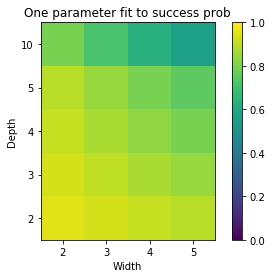

In [61]:
ax = plt.gca()
img = ax.imshow(Z_fit, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)


ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('One parameter fit to success prob')
plt.show()

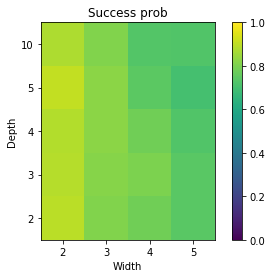

In [62]:
ax = plt.gca()
img = ax.imshow(Zdata, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)


ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Success prob')
plt.show()

**Two parameter model**

In [63]:
# pguess2d_exp = [0.0276, 0.01, 0.4]
# popt2d, pcov2d = curve_fit(two_param_exp, xdata, data_1d.ravel(), p0=pguess2d, bounds=(0., 1))

In [64]:
popt2d, pcov2d = curve_fit(two_param, xdata, data_1d.ravel(), bounds=(0., 1))

In [65]:
popt2d

array([0.05877651, 0.00253226])

In [66]:
zfit2d = two_param(xdata, popt2d[0], popt2d[1])
Z_fit2d = zfit2d.reshape(shape)
print(Z_fit2d)

[[0.88142068 0.82961385 0.78085204 0.73495628]
 [0.87918869 0.82751305 0.77887472 0.73309518]
 [0.87696236 0.82541757 0.77690241 0.7312388 ]
 [0.87474167 0.8233274  0.77493509 0.72938711]
 [0.86372226 0.81295568 0.76517298 0.72019878]]


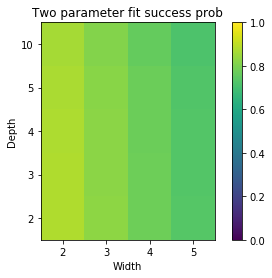

In [67]:
ax = plt.gca()
img = ax.imshow(Z_fit2d, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0, vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Two parameter fit success prob')
plt.show()

## Plot the distribution of sublattice widths

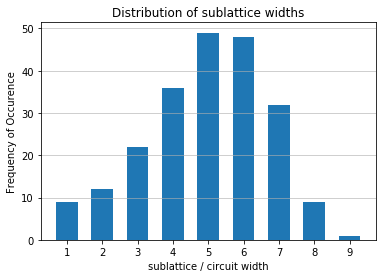

In [68]:
G = perfect_qc.qubit_topology()
len(perfect_qc.qubit_topology())
# distribution of graph lengths
distr = []
for num_nodes in range(1, len(G.nodes) + 1):
    listg = generate_connected_subgraphs(G, num_nodes)
    distr.append(len(listg))

cir_wid = list(range(1, len(G.nodes) + 1))
plt.bar(cir_wid, distr, width=0.61, align='center')
plt.xticks(cir_wid)
plt.xlabel('sublattice / circuit width')
plt.ylabel('Frequency of Occurence')
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of sublattice widths')
plt.show()